In [1]:
%pylab inline
import radvel
import radvel.model
import radvel.likelihood
import radvel.posterior
import radvel.mcmc
import radvel.prior
import corner

import copy
from scipy import optimize
rc('savefig',dpi=120)

# Convenient function for plotting fits
def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(like.x, like.model(like.x))
    fig.set_tight_layout(True)
    xlabel('Time')
    ylabel('RV')
    draw()

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days
/Users/petigura/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


Intialize Keplerian model parameters
====================================

In [2]:
params = radvel.RVParameters(1,basis='per tc secosw sesinw k')
params['k1'] = 1
params['per1'] = 1
params['secosw1'] = 0.1
params['sesinw1'] = +0.5
params['tc1'] = 0.
mod = radvel.RVModel(params)

Generate Synthetic Data
=======================

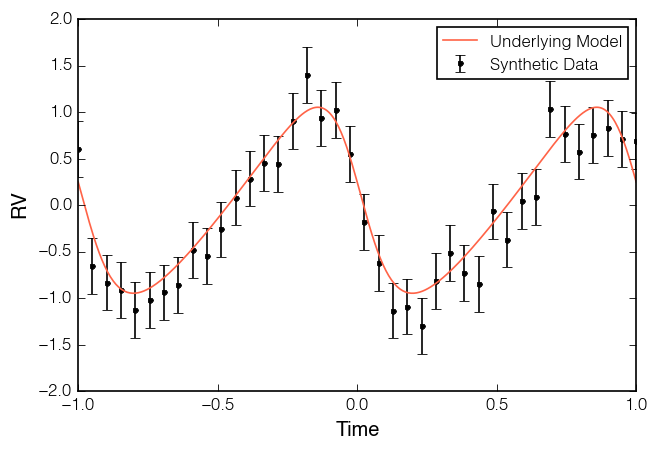

In [3]:
t = np.linspace(-1,1,40)
ti = np.linspace(-1,1,400)
errvel = 0.3
syn_rv = mod(t) + randn(t.size)*errvel
errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plot(ti,mod(ti),label='Underlying Model')
xlabel('Time')
ylabel('RV')
legend()

Generate a likelihood
=====================

In [4]:
like_syn = radvel.likelihood.RVLikelihood(mod,t,syn_rv,zeros(t.size)+errvel)
like_syn.params['gamma'] = 0
like_syn.params['logjit'] = np.log(errvel)

truths = copy.deepcopy(like_syn.params) # Store away model parameters for later reference
like_syn.params.update(dict(k1=3,secosw1=0.1,sesinw1=0.1,tc1=0.1)) # perturb the starting guess
like_syn.vary['logjit'] = False # Don't vary jitter



Perform a maximum likelihood fit
===============================

  status: 0
    nfev: 1094
 success: True
     fun: 7.0878750025162844
       x: array([ 0.05538061,  1.00653873, -0.00244756,  0.02226234,  1.08485423,
        0.54704873, -0.08608991])
 message: 'Optimization terminated successfully.'
     nit: 720
parameter                value       vary
dvdt                -0.0024471       True
gamma               -0.0860736       True
k1                     1.08482       True
logjit                -1.20397      False
per1                   1.00655       True
secosw1              0.0553166       True
sesinw1               0.547043       True
tc1                  0.0222756       True



/Users/petigura/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


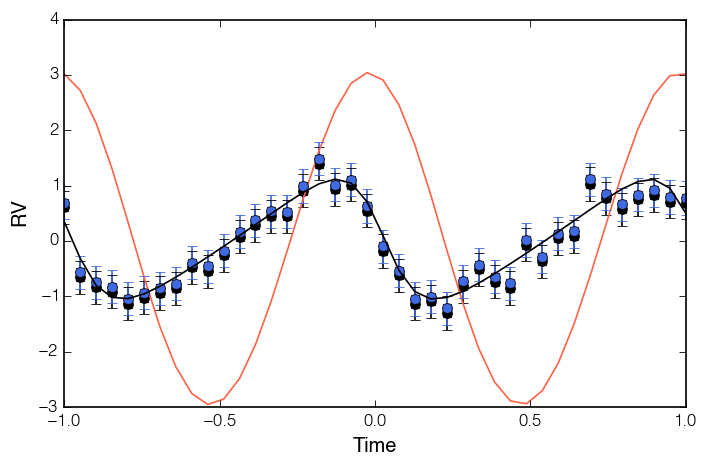

In [5]:
plot_results(like_syn) # Plot initial model
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B' )
print res
print like_syn
plot_results(like_syn) # plot best fit model
#plot(ti, like_syn.residuals(),'.')


Instantiate a posterior object
===============================

In [6]:
reload(radvel.prior)
post = radvel.posterior.Posterior(like_syn)
post.params.update(dict(per1=1,k1=1))
post.vary['logjit'] = True
post.priors += [radvel.prior.EccentricityPrior( 1 )]
post.priors += [radvel.prior.Gaussian( 'logjit', log(errvel), 0.1)]
post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]
post.priors += [radvel.prior.Gaussian( 'tc1', 0, 0.1)]

print post.priors
print post

[Generic Prior, Gaussian Prior on logjit, mu=-1.20397280433, sigma=0.1, Gaussian Prior on per1, mu=1, sigma=0.1, Gaussian Prior on tc1, mu=0, sigma=0.1]
parameter                value       vary
dvdt                -0.0024471       True
gamma               -0.0860736       True
k1                           1       True
logjit                -1.20397       True
per1                         1       True
secosw1              0.0553166       True
sesinw1               0.547043       True
tc1                  0.0222756       True
Priors
------
Generic Prior
Gaussian Prior on logjit, mu=-1.20397280433, sigma=0.1
Gaussian Prior on per1, mu=1, sigma=0.1
Gaussian Prior on tc1, mu=0, sigma=0.1



Perform maximum likelihood fit on posterior
=========================================

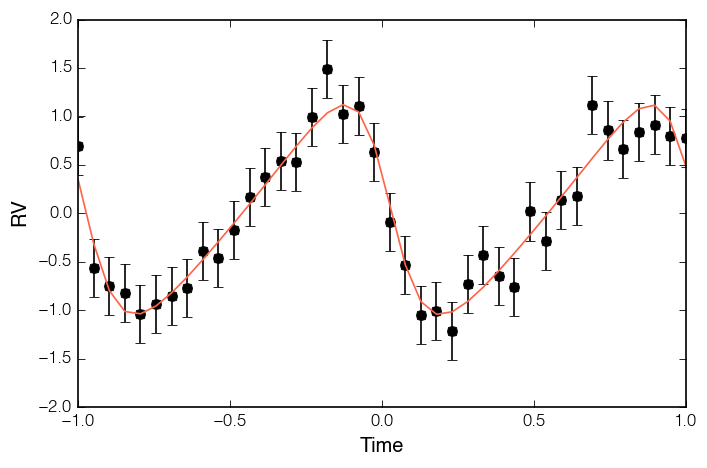

In [7]:
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
plot_results(post.likelihood)

Use mcmc to sample the posterior distribution
========================

1. use `emcee` package to run MCMC
1. corner plot visualizes parameters and correlations
1. Blue lines show the synthetic model parameters

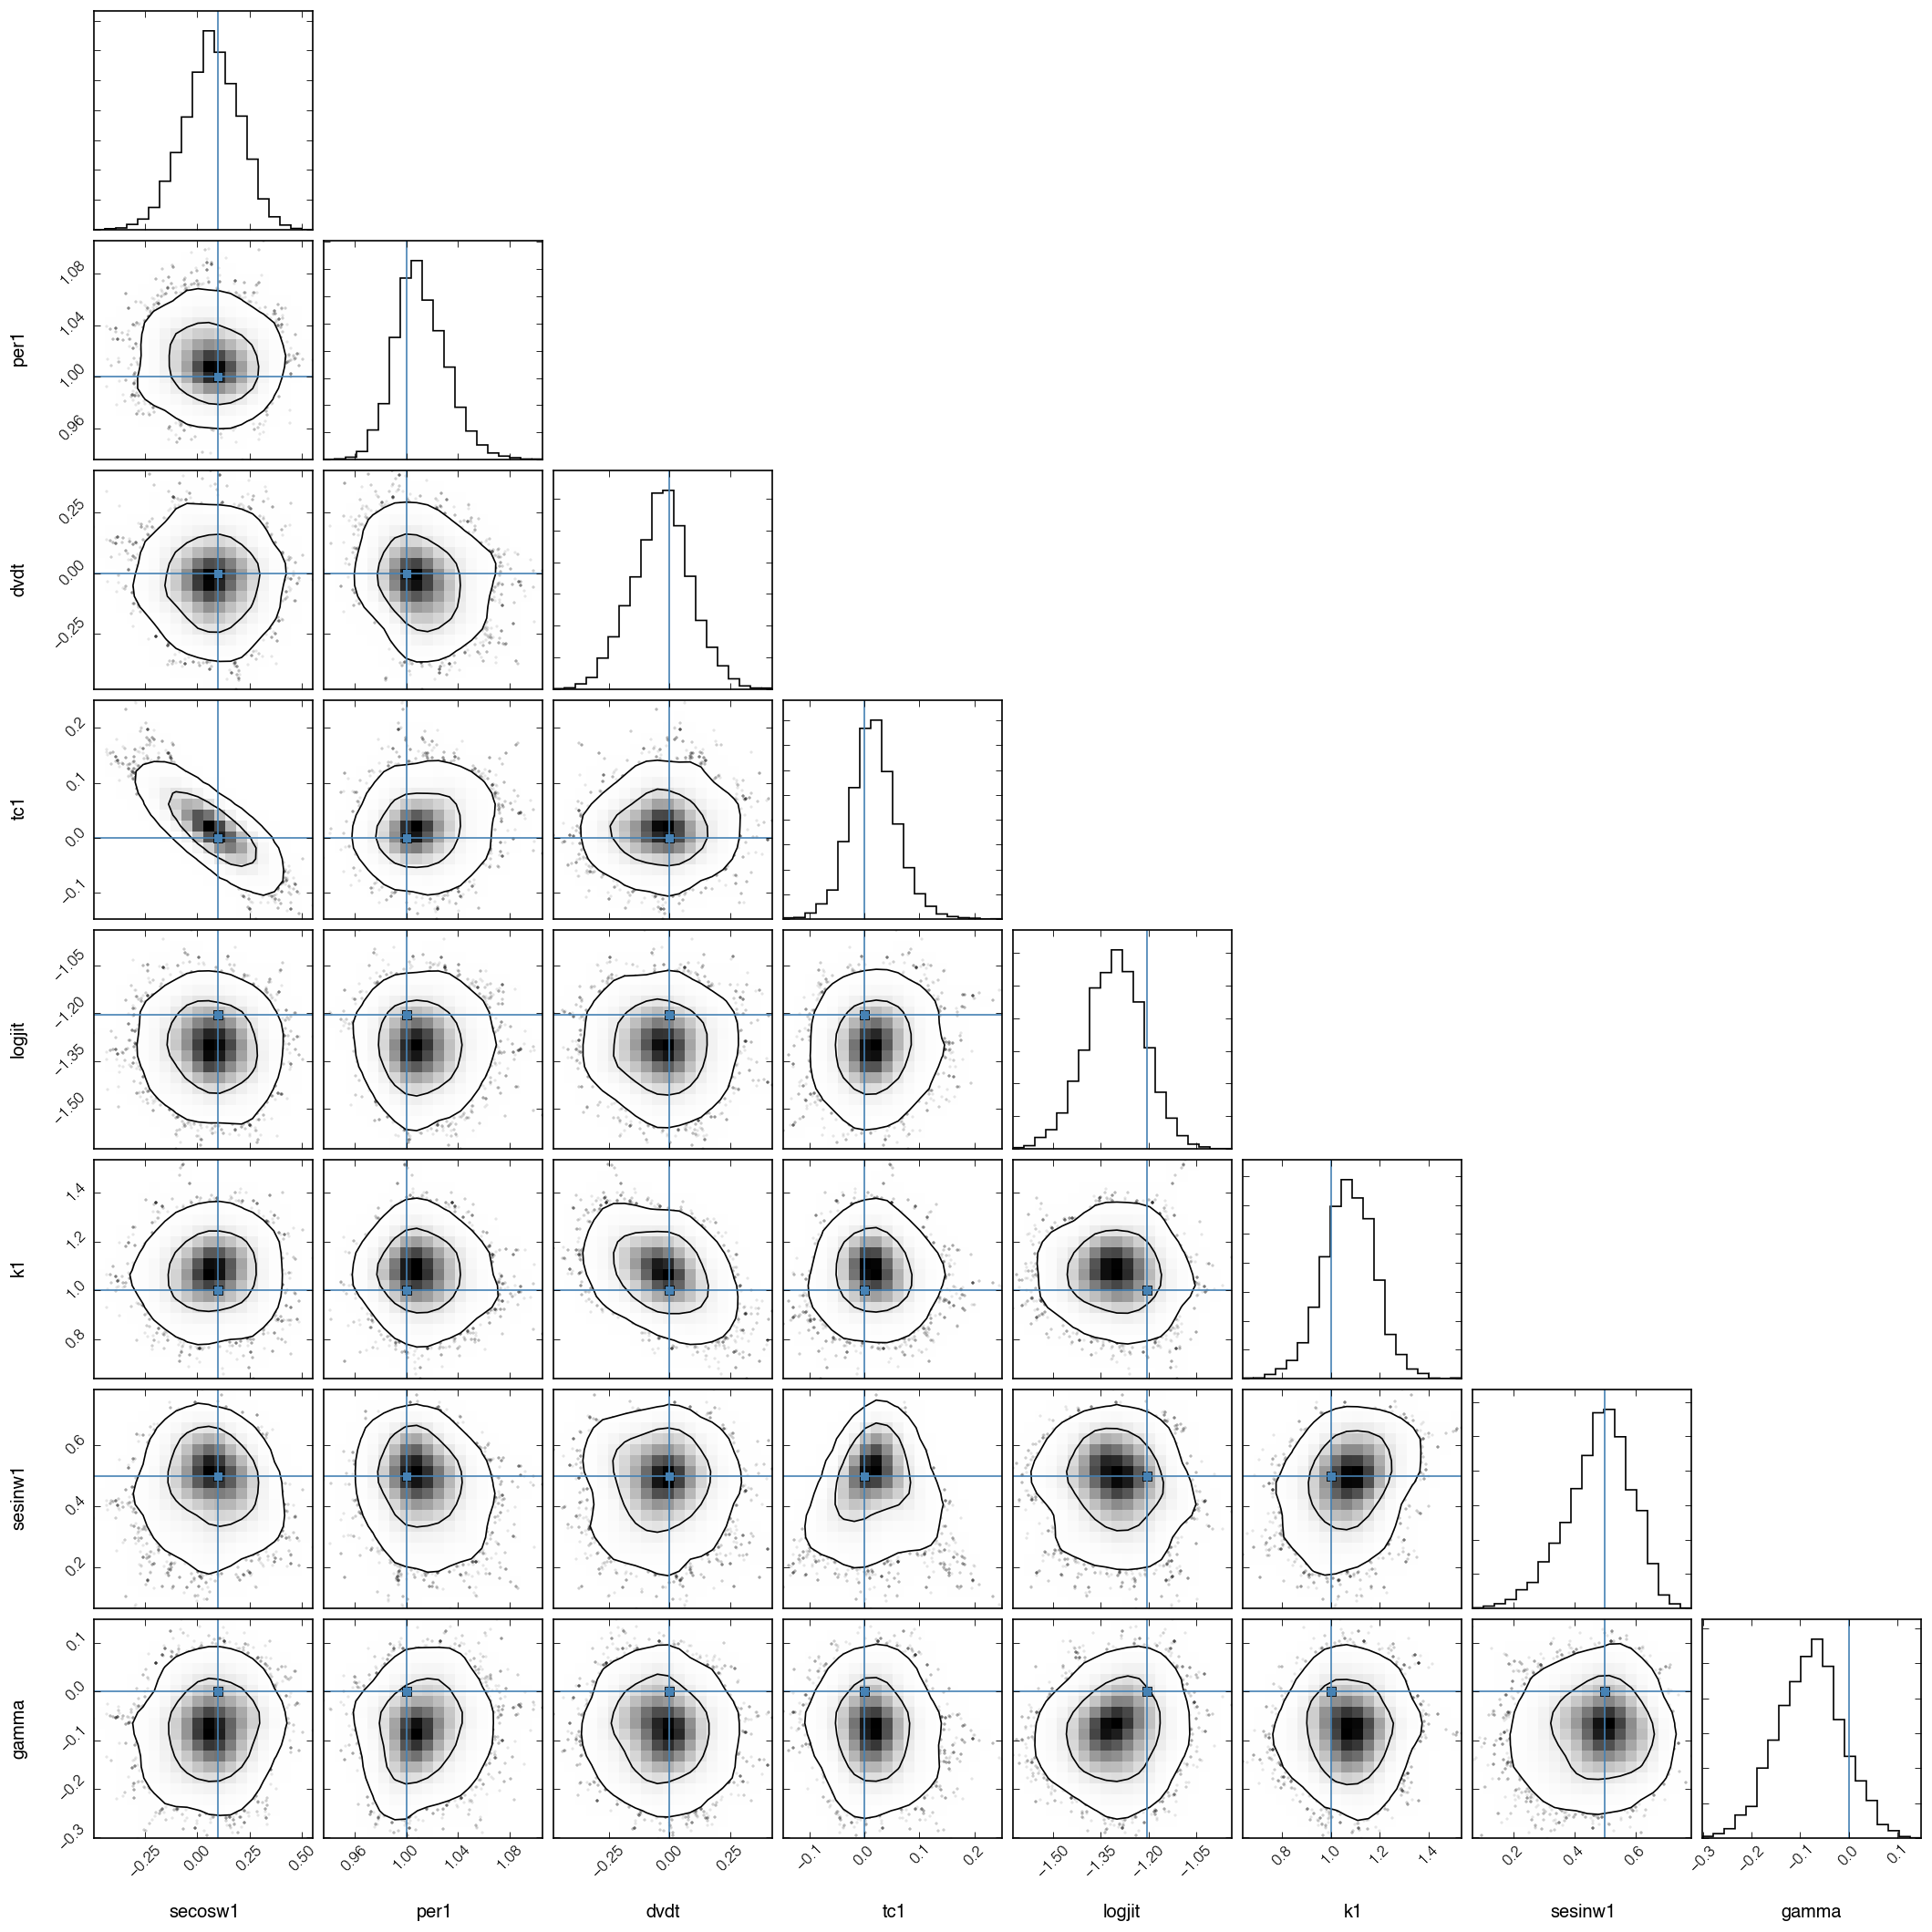

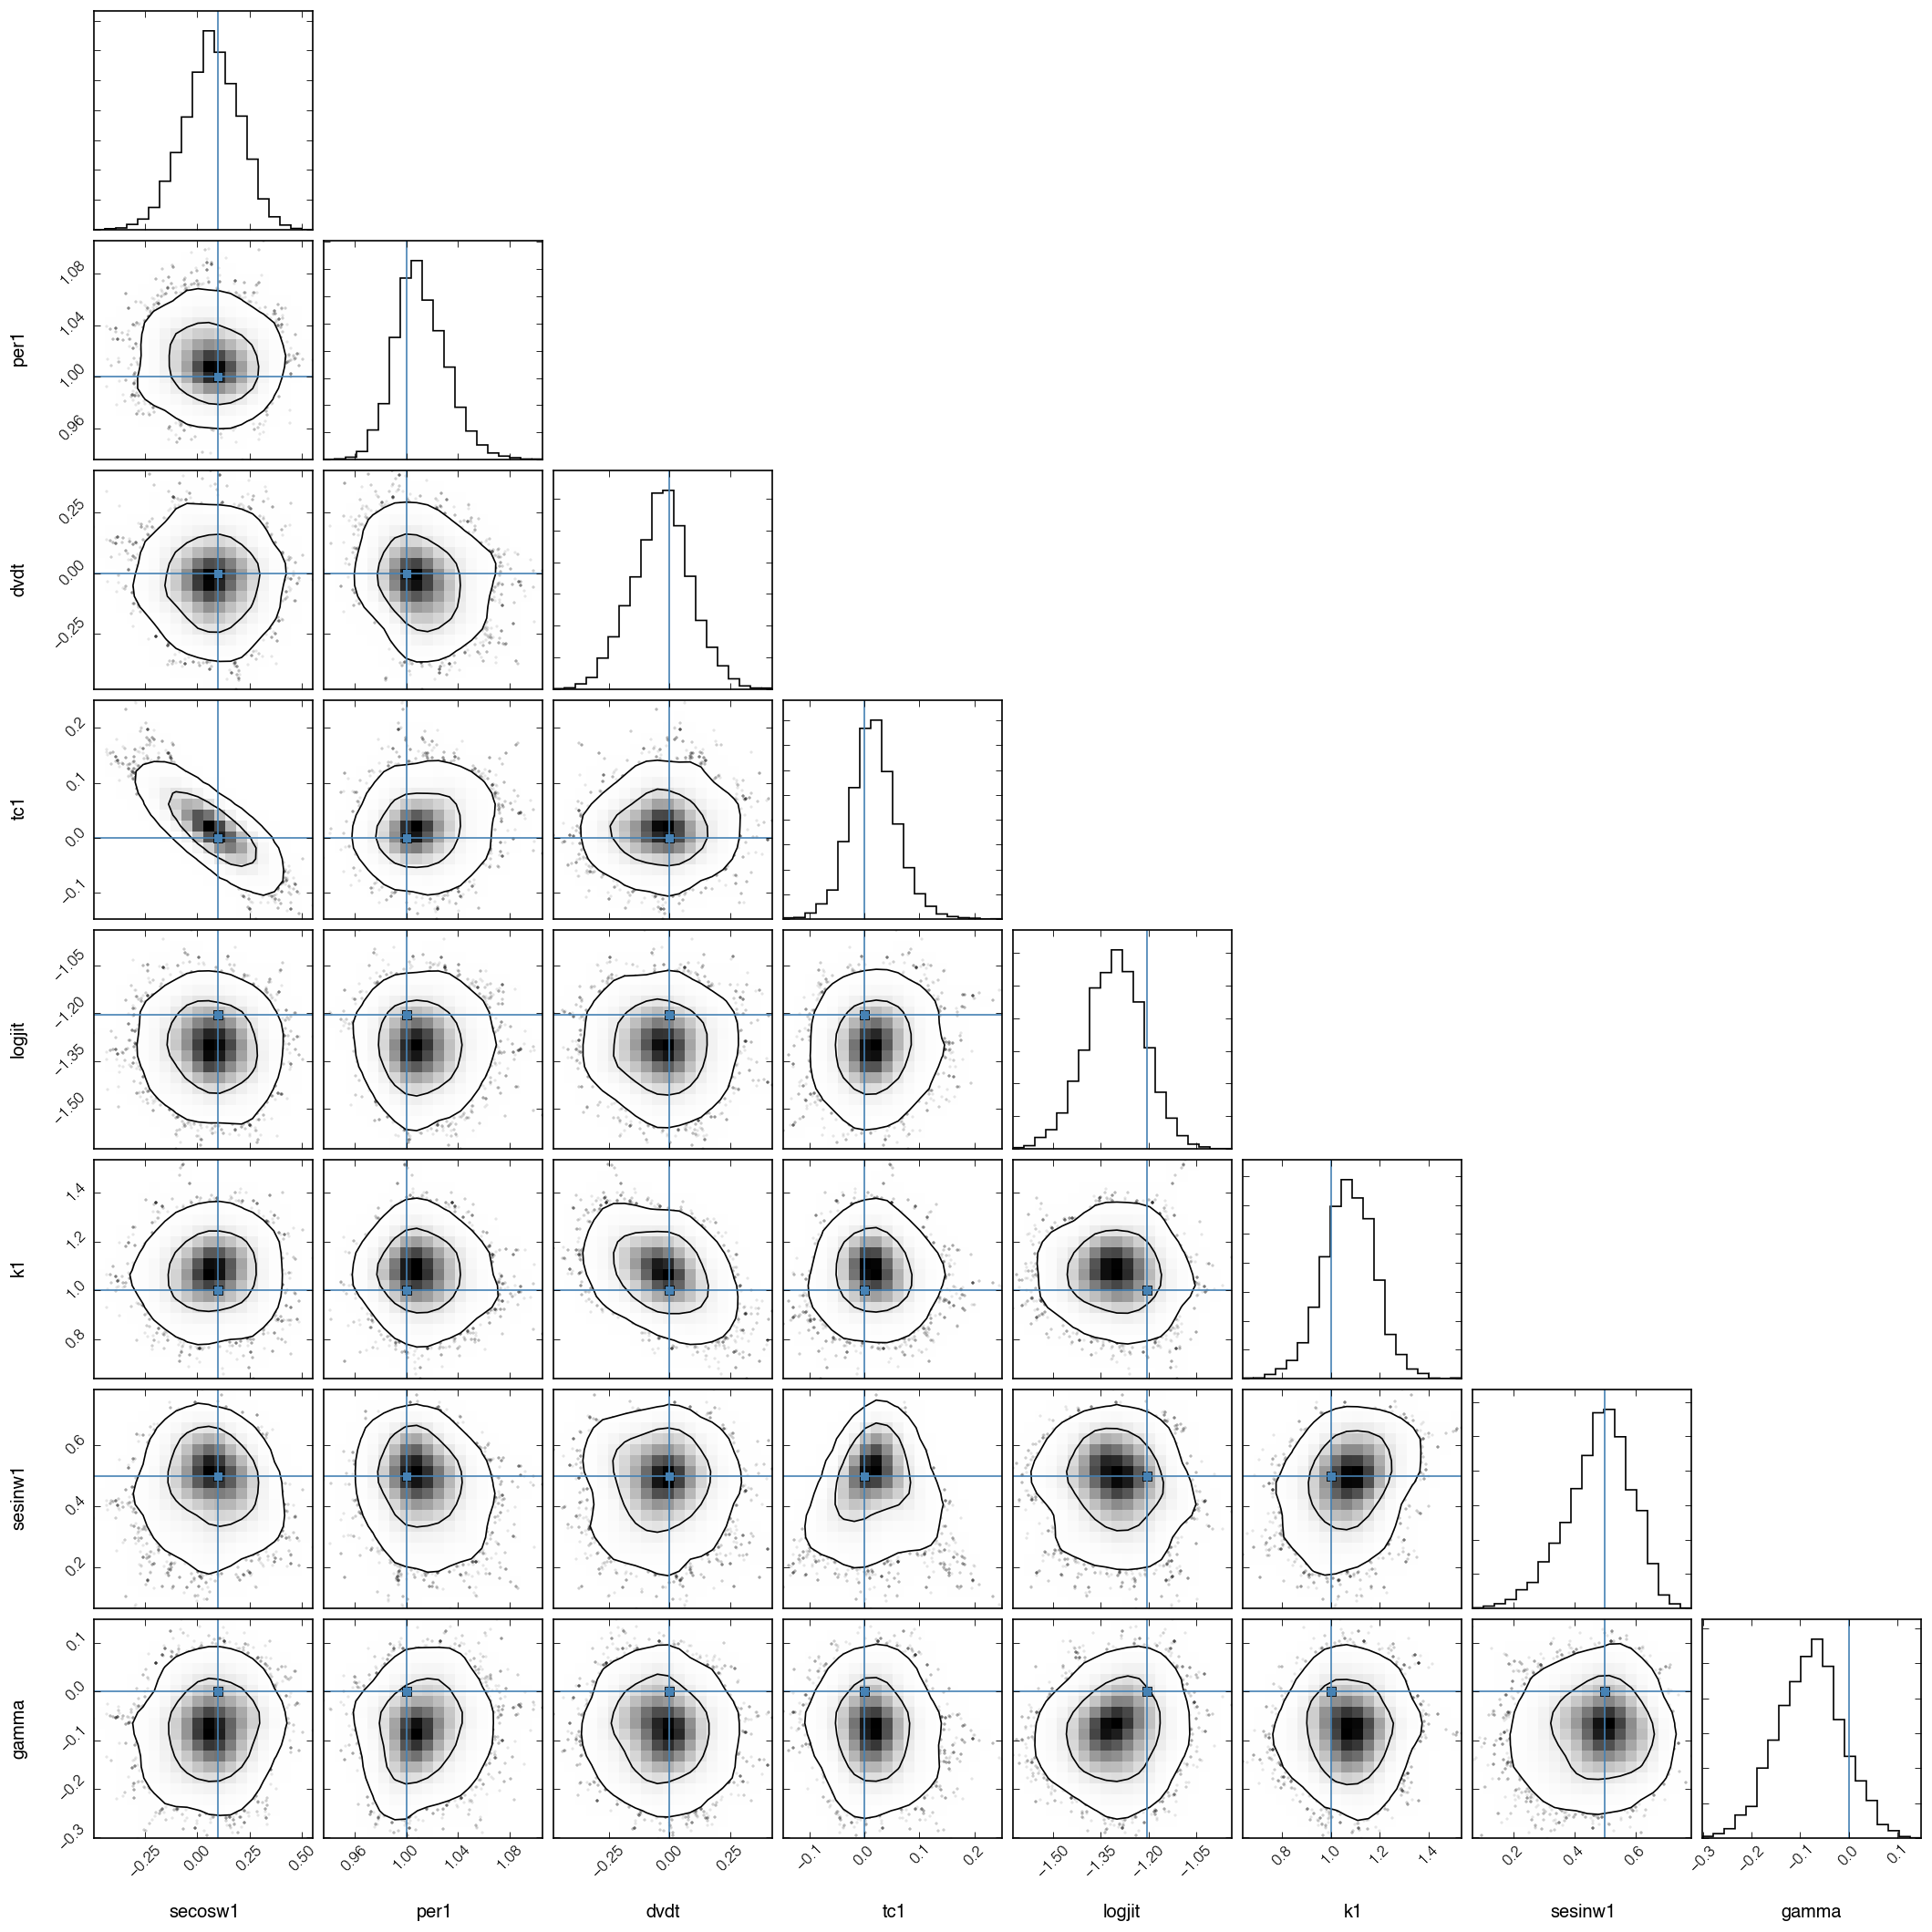

In [8]:
df = radvel.mcmc.mcmc(post,threads=1,nburn=100,nwalkers=20,nrun=1000)
labels = [k for k in post.vary.keys() if post.vary[k]]
corner.corner(
    df[labels],labels=labels,truths=[truths[k] for k in labels ],
    levels=[0.68,0.95],plot_datapoints=True,smooth=True)

(array([   20.,    32.,   103.,   252.,   658.,  1775.,  3515.,  5639.,
         5903.,  2103.]),
 array([-21.90236421, -20.33629905, -18.7702339 , -17.20416874,
        -15.63810359, -14.07203843, -12.50597328, -10.93990812,
         -9.37384297,  -7.80777781,  -6.24171266]),
 <a list of 10 Patch objects>)

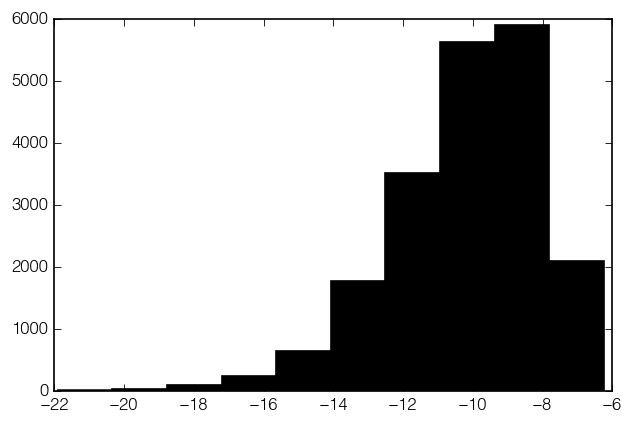

In [9]:
hist(df.lnprobability)